# Long candle strategy  EDA

Long candle strategy is classification model.
Features: prices
Targets: -1,0,1 signal

To install conda and binance packages to this notebook uncomment the code below

In [1]:
%%capture
#%conda install -c plotly plotly=5.9.0
#%conda install pip
#%conda install twisted
%pip install plotly==5.9.0
%pip install twisted
%pip install pandas
#%pip install huobi-sdk==2.3.3

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

In [2]:
#mode="dev" # dev - work with local dev data
mode="yc" # yc - work with data from yandex cloud bots

symbol="BTC-USDT"
strategy="LongCandleDenseStrategy"

In [3]:

import os

# Downloading latest pytrade2 data
if mode == "yc":
    os.system("cd ./../deploy/yandex_cloud; ./download_data.sh")
    data_dir=f"../data/yandex-cloud"
else:
    data_dir=f"../data/dev"
    
print(f"Download completed. Local data dir: {data_dir}")

    

deploy_lib.sh: line 4: yc: command not found
INFO: Retrieving list of remote files for s3://pytrade2/data/ ...


Sync pytrade2 data from s3://pytrade2/data to /home/dima/projects/pytrade2/deploy/yandex_cloud/../../data/yandex-cloud


INFO: No cache file found, creating it.
INFO: Compiling list of local files...
INFO: Running stat() and reading/calculating MD5 values on 1762 files, this may take some time...
INFO: [1000/1762]


download: 's3://pytrade2/data/LongCandleDenseStrategy/Xy/2023-10-26_BTC-USDT_learn_x.csv' -> '/home/dima/projects/pytrade2/deploy/yandex_cloud/../../data/yandex-cloud/LongCandleDenseStrategy/Xy/2023-10-26_BTC-USDT_learn_x.csv'  [1 of 10]
LongCandleDenseStrategy last opened: , closed: 
LSTMStrategy last opened: 2023-08-01 15:34:15.711000, closed: 2023-08-01 15:43:49.187000
LSTMStrategy2 last opened: , closed: 
SimpleKerasStrategy last opened: 2023-07-07 17:06:28.241000, closed: 2023-07-07 17:11:10.986000
Current time Чт 26 окт 2023 18:13:11 UTC
Download completed. Local data dir: ../data/yandex-cloud


INFO: Found 92 remote files, 1762 local files
INFO: Verifying attributes...
INFO: disabled md5 check for LongCandleDenseStrategy/Xy/2023-10-07_BTC-USDT_x.csv
INFO: disabled md5 check for LongCandleDenseStrategy/Xy/2023-10-08_BTC-USDT_x.csv
INFO: disabled md5 check for LongCandleDenseStrategy/Xy/2023-10-09_BTC-USDT_x.csv
INFO: Summary: 10 remote files to download, 1675 local files to delete, 0 local files to hardlink
ERROR: Download of 'LongCandleDenseStrategy/Xy/2023-10-26_BTC-USDT_learn_x.csv' failed (Reason: Unknown OsError 0)
ERROR: Exiting now because of fatal error

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    An unexpected error has occurred.
  Please try reproducing the error using
  the latest s3cmd code from the git master
  branch found at:
    https://github.com/s3tools/s3cmd
  and have a look at the known issues list:
    https://github.com/s3tools/s3cmd/wiki/Common-known-issues-and-their-solutions
  If the error persists, please report the
  following lines (removing any 

## Predicted and actual low/high

In [4]:
import os
import glob
import pandas as pd
from datetime import timedelta,date
import matplotlib.pyplot as plt
import plotly.express as px

def read_last(symbol: str, name: str, n=1000):
    xy_dir=f"{data_dir}/{strategy}/Xy"

    file_path = sorted([f for f in os.listdir(xy_dir) if f.endswith(f"{symbol}_{name}.csv")])[-1]
    file_path = f"{xy_dir}/{file_path}"
    print(f"Read from {file_path}")
    return pd.read_csv(file_path, parse_dates=True).tail(n)


def read_last_xy(data_dir):
    """ Read days from start to end from local predictions history"""
    
    #data=read_last(symbol, "data", n)
    X=read_last(symbol, "x")
    y=read_last(symbol, "y").set_index('close_time')
    data=pd.merge(X,y, left_index=True, right_index=True) 
    #y=pd.concat([data,y])
    return data,X,y


# Read candles for last 3 days
print(symbol)
data,x,y = read_last_xy(data_dir)
y.tail()


BTC-USDT
Read from ../data/yandex-cloud/LongCandleDenseStrategy/Xy/2023-10-25_BTC-USDT_x.csv
Read from ../data/yandex-cloud/LongCandleDenseStrategy/Xy/2023-10-25_BTC-USDT_y.csv


,signal_pred,signal_actual
close_time,,
2023-10-25 19:18:04.991,-1,-1
2023-10-25 19:19:08.705,0,0
2023-10-25 19:20:12.142,1,1
2023-10-25 19:21:15.800,0,0
2023-10-25 19:22:19.395,0,0


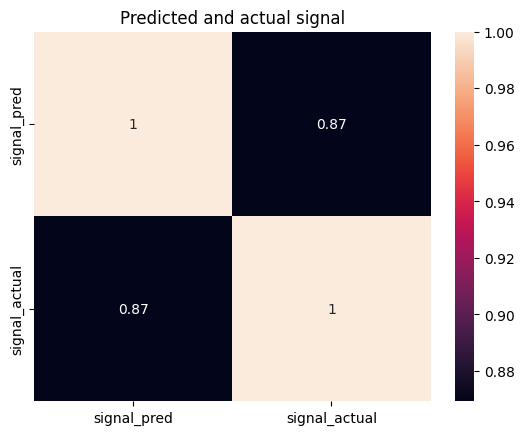

In [5]:
import seaborn as sns

sns.heatmap(y.corr(), annot=True)
plt.title('Predicted and actual signal')
plt.show()

<AxesSubplot:>

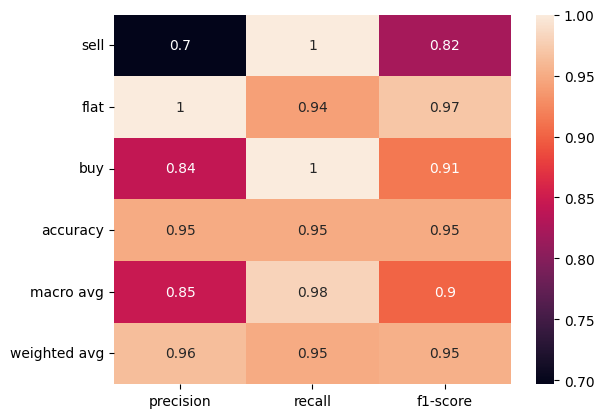

In [6]:
from sklearn.metrics import classification_report

clf_report = classification_report(y['signal_actual'],
                                   y['signal_pred'],
                                   #labels=['sell', 'flat', 'buy'],
                                   target_names=['sell', 'flat', 'buy'],
                                   output_dict=True)
#print(clf_report)
#sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
#sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :-3].T[::-1], annot=True)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)

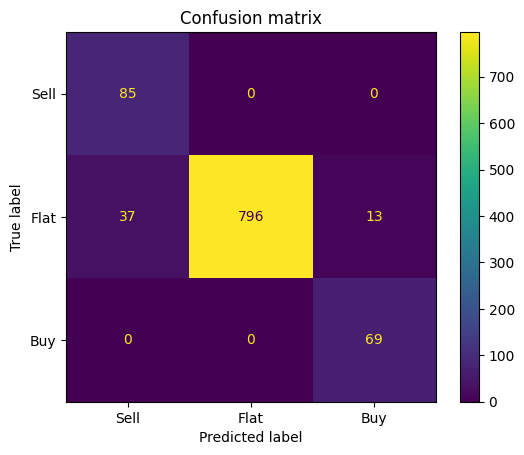

[[ 85   0   0]
 [ 37 796  13]
 [  0   0  69]]


In [7]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y['signal_actual'], y['signal_pred'])

metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Sell', 'Flat', 'Buy']).plot()
plt.title('Confusion matrix')
plt.show()
print(confusion_matrix)

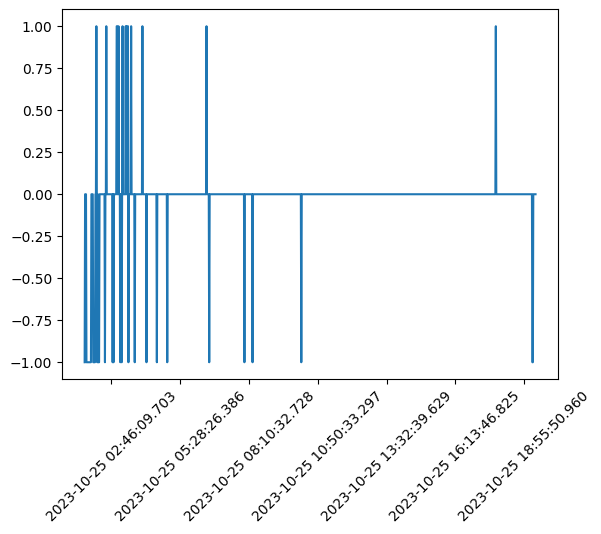

In [58]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.plot(y.index, y['signal_pred']-y['signal_actual'])
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=5))
plt.xticks(rotation=45)

#ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
#plt.gca().xaxis.set_major_formatter(ConsizeDateFormatter())
plt.show()

In [76]:
import plotly.express as px
px.bar(x=y.index, 
    y=y['signal_pred']-y['signal_actual'], 
    title='Predicted and actual signal difference. diff = predicted - actual',
    labels = {'x': 'time', 'y':'predicted - actual'}
      ).show()